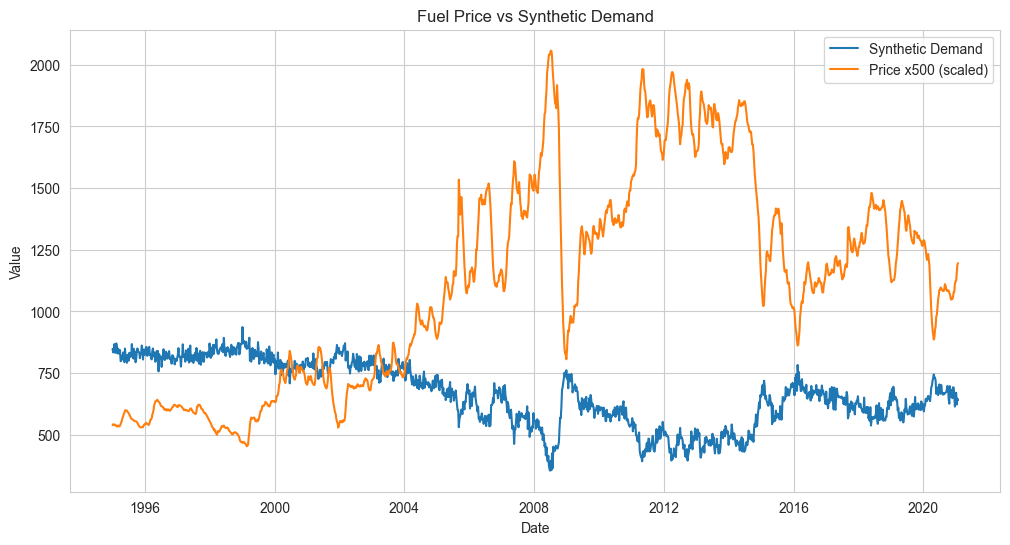

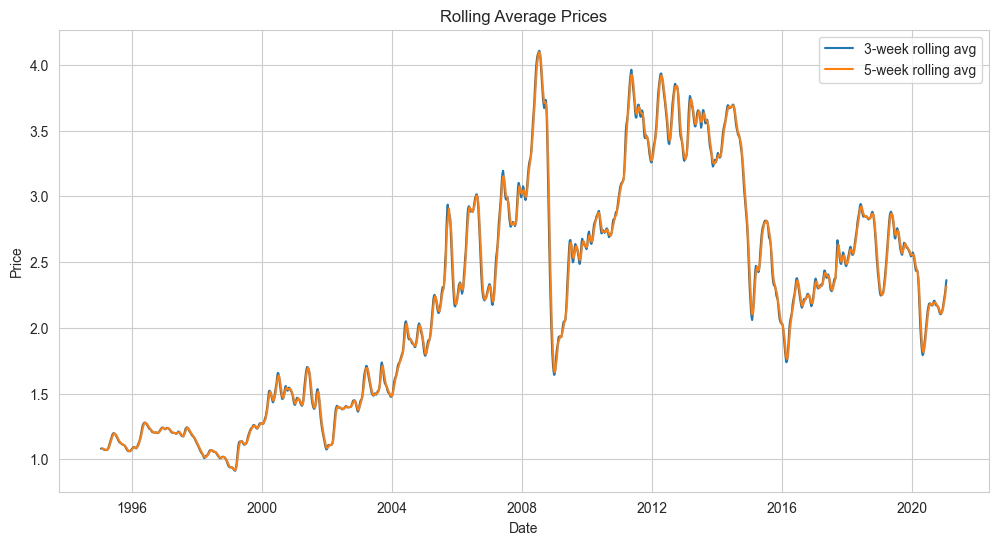

In [ ]:
# Dynamic Fuel Pricing Optimization
# EDA, Modeling, and Optimization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_processing import load_data
from src.feature_engineering import create_features
from src.model_training import train_model, evaluate_model
from src.optimization import optimize_prices
from src.evaluation import summarize_results

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)


# Load dataset
df = load_data("../data/PET_PRI_GND_DCUS_NUS_W.csv")
df = df.rename(columns={'R1': 'Price'})

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Generate synthetic demand
np.random.seed(42)
df['Demand'] = 1000 - 150 * df['Price'] + np.random.normal(0, 20, size=len(df))

# 4a: Raw Price and Demand over time
plt.plot(df['Date'], df['Demand'], label='Synthetic Demand')
plt.plot(df['Date'], df['Price']*500, label='Price x500 (scaled)')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Fuel Price vs Synthetic Demand")
plt.legend()
plt.show()

# 4b: Rolling averages of price
df['Price_roll3'] = df['Price'].rolling(window=3).mean()
df['Price_roll5'] = df['Price'].rolling(window=5).mean()

plt.plot(df['Date'], df['Price_roll3'], label='3-week rolling avg')
plt.plot(df['Date'], df['Price_roll5'], label='5-week rolling avg')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Rolling Average Prices")
plt.legend()
plt.show()


In [ ]:
# Feature Engineering
df = create_features(df)

# Train/Test Split
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

X_train = train.drop(columns=['Demand'])
y_train = train['Demand']
X_test = test.drop(columns=['Demand'])
y_test = test['Demand']

# Drop Date column (XGBoost cannot handle datetime)
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

# Train Model
model = train_model(X_train, y_train)

# Evaluate Model
rmse, mape = evaluate_model(model, X_test, y_test)
print(f"RMSE: {rmse:.2f}, MAPE: {mape:.4f}")

# Optimize Prices
recommended_prices, actual_profits, optimized_profits = optimize_prices(
    model, X_test, y_test
)

# Backtesting & Summary
total_actual, total_optimized, improvement = summarize_results(
    actual_profits, optimized_profits
)

print(f"Total Actual Profit: {total_actual:.2f}")
print(f"Total Optimized Profit: {total_optimized:.2f}")
print(f"Total Profit Improvement: {improvement:.2f}")

RMSE: 21.87, MAPE: 0.0274
Total Actual Profit: 52057.93
Total Optimized Profit: 132731.35
Total Profit Improvement: 80673.41


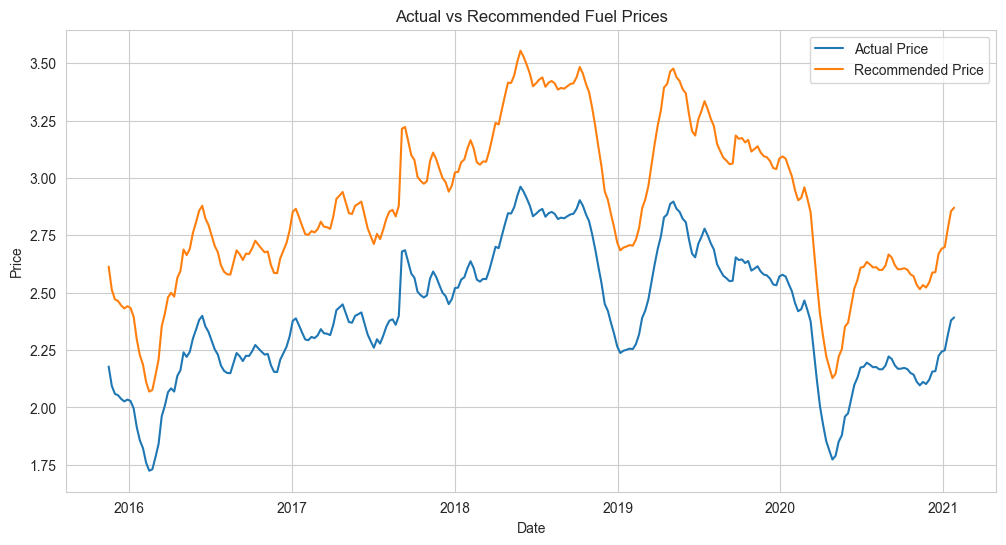

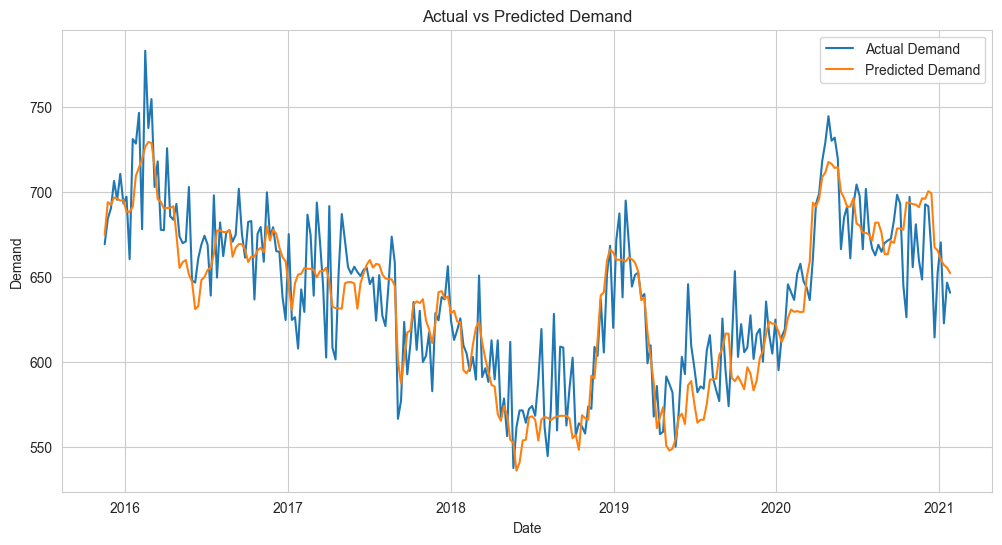

In [ ]:
# Recommended vs Actual Prices
plt.plot(df['Date'].iloc[-len(recommended_prices):], X_test['Price'], label='Actual Price')
plt.plot(df['Date'].iloc[-len(recommended_prices):], recommended_prices, label='Recommended Price')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual vs Recommended Fuel Prices")
plt.legend()
plt.show()

# Visualization: Actual vs Predicted Demand
predicted_demand = model.predict(X_test)
plt.plot(df['Date'].iloc[-len(predicted_demand):], y_test.values, label='Actual Demand')
plt.plot(df['Date'].iloc[-len(predicted_demand):], predicted_demand, label='Predicted Demand')
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Actual vs Predicted Demand")
plt.legend()
plt.show()